In [ ]:
#r "nuget: Microsoft.Data.SqlClient, *-*"
#r "nuget:ScottPlot, 5.0.*"

#### Enter a person's name

In [ ]:
#!set --name personName --value @input:"Enter a person's name"

#### Choose a random person's name

In [92]:
var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

string personName;

using (var connection = new SqlConnection(connectionString))
using (var command = connection.CreateCommand())
{
    connection.Open();
    command.CommandType = CommandType.Text;
    command.CommandText = "select top 1 PersonName from Transactions order by newid()";

    personName = (await command.ExecuteScalarAsync()).ToString();
}

Console.WriteLine($"Randomly chose {personName}");

Randomly chose Robert Lewis


#### Search our database and populate some data about that person

In [93]:
using System.IO;
using System.Data;
using Microsoft.Data.SqlClient;
using ScottPlot;
using Microsoft.DotNet.Interactive.Formatting;

Formatter.Register(typeof(ScottPlot.Plot), (p, w) => 
    w.Write(((ScottPlot.Plot)p).GetPngHtml(800, 600)), HtmlFormatter.MimeType);

public class Transaction
{
    public int Id { get; set; }
    
    public DateTime Date { get; set; }

    public DateTime TimeStamp { get; set; }

    public string PersonName { get; set; }

    public string Outlet { get; set; }

    public string Category { get; set; }

    public decimal Amount { get; set; }

    public string TransactionType { get; set; }

    public override string ToString() => $"{PersonName} {(TransactionType == "expense" ? "spent" : "gained")} £{Amount} on {Outlet} Transaction id {Id}.";
}

public async Task<List<Transaction>> GetTransactions(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();

        var result = new List<Transaction>();

        while (await reader.ReadAsync())
        {
            result.Add(new Transaction
            {
                Id = (int)reader["Id"],
                Date = (DateTime)reader["Date"],
                TimeStamp = (DateTime)reader["TimeStamp"],
                PersonName = (string)reader["PersonName"],
                Outlet = (string)reader["Outlet"],
                Category = (string)reader["Category"],
                Amount = (decimal)reader["Amount"],
                TransactionType = (string)reader["TransactionType"],
            });
        }

        return result;
    }
}

public async Task<List<(decimal Amount, string VendorName)>> GetGroupedAmounts(string sqlQuery)
{
    var connectionString = await File.ReadAllTextAsync(@"C:\\Temp\BestFunds.txt");

    using (var connection = new SqlConnection(connectionString))
    using (var command = connection.CreateCommand())
    {
        connection.Open();
        command.CommandType = CommandType.Text;
        command.CommandText = sqlQuery;

        using var reader = await command.ExecuteReaderAsync();

        var result = new List<(decimal, string)>();

        while (await reader.ReadAsync())
        {
            result.Add(((decimal)reader["Amount"], (string)reader["Category"]));
        }

        return result;
    }
}

Console.WriteLine("Getting transactions...");
var transactions = await GetTransactions($"Select top 100 * from Transactions where PersonName = '{personName}'");
Console.WriteLine("Finished getting transactions");
Console.WriteLine("Getting spending by category...");
var groupedAmounts = await GetGroupedAmounts($"select sum(Amount) as Amount, Category from Transactions where PersonName = '{personName}' and TransactionType = 'expense' group by Category");
Console.WriteLine("Finished getting spending by category");

Getting transactions...
Finished getting transactions
Getting spending by category...
Finished getting spending by category


#### Display the data

Displaying spending by category for Robert Lewis



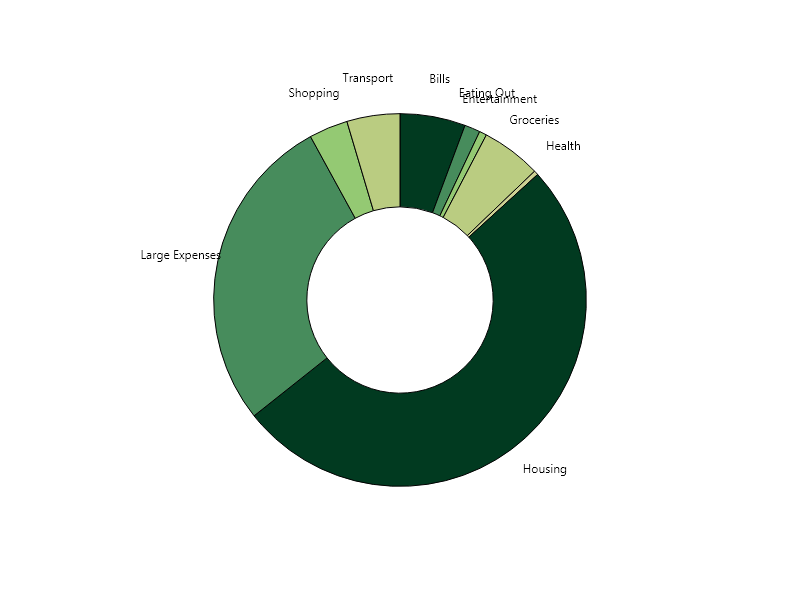

In [94]:
ScottPlot.Plot myPlot = new();

var palette = new ScottPlot.Palettes.Nero();

List<PieSlice> slices = groupedAmounts.Select((a, i) => new PieSlice() 
{
    Value = decimal.ToDouble(a.Amount),
    Label = a.VendorName,
    FillColor = palette.GetColor(i % palette.Colors.Count()), 
}).ToList();

var pie = myPlot.Add.Pie(slices);
pie.DonutFraction = .5;

myPlot.ShowLegend();

myPlot.Axes.Frameless();
myPlot.HideGrid();

Console.WriteLine($"Displaying spending by category for {personName}");

myPlot